# Speech Recognition using an LSTM

<font color="navy">
This tutorial is an introduction to prediction (classification) using Long Short-Term Memory (LSTM) networks for speech/audio data. For the sake of this tutorial, use a simple speech data containing only three types of speech words (more details later).

We use LSTMs given their expressiveness in capturing temporal patterns and representing them in a compact latent representation (read hidden cells). We use this idea to find out a latent representation of a speech word that captures the complete history of the audio and then use this representation to classify the sample using a simple logistic regressor.
</font>

In [0]:
%matplotlib inline

This allows the plots generated by matplotlib (and seaborn) to show inline in the notebook. This is useful to view plots easily from the jupyter notebook itself

In [8]:
# global imports

import os
import sys
import glob
import dill
import librosa
import numpy as np
import matplotlib.pyplot as plt

from os import path
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split

Using TensorFlow backend.


In [1]:
# Upload data.zip file from this week's courseworks folder to Google Drive.  (takes 10-15 mins)
# "Mount" the drive and then unzip it using the following code.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Example from My Google Drive path.  Puts unzipped data.zip files in colab /content/ directory
! unzip '/content/drive/My Drive/Projects in Advanced Machine Learning/Week 11/data.zip'

We import all the libraries we would need later. The purposes of each library/function are explained wherever they are used

In [27]:
# defining some global variables

PATH = path.abspath(path.join(os.getcwd(), "../.."))

dataset_name = "simple-speech-data"
DATA_PATH = path.join(PATH, "/content/data/{}".format(dataset_name))

DATA_PATH


'/content/data/simple-speech-data'

This defines global paths that allow us to read data files and store/load saved models. The assert statements ensure if the corresponding paths exist on the file system or not

Note: If you see an error saying the data path was not found, you haven't downloaded the data. In order to do so, refer to the main README in the repository.

In [0]:
# add root directory to system path

sys.path.append(PATH)

This would allow us to use the shareai api in the root directory

In [0]:
# initialize the set of labels from the speech dataset we are going to train our network
# on

CLASSES = ["bed", "happy", "cat"]

for cl in CLASSES:
    assert path.exists(path.join(DATA_PATH, cl)), f"Path does not exist for class {cl}"

This defines the list of classes that we have in our dataset. This is primarily just used to reading data files. The assert statements ensure we have all classes in our data directory

## Reading Data (takes time!)

In [0]:
data = []

for cl in CLASSES:
    # get list of files in a class directory
    files = glob.glob(path.join(DATA_PATH, cl + "/*"))

    for fp in files:
        # load audio features using librosa
        audio = librosa.load(fp, mono=True, sr=None)[0] # args read in raw audio data without conversions
                                                        # Note that you can also read in audio to a specific length with "duration" argument
        data.append((audio, cl))

For each class, we read the filenames of all files in that class directory and load them using (librosa)[https://librosa.github.io/librosa/], which is a popular library for manipulating audio files. We will be using this library for all manipulations in order to do feature extraction throughout the tutorial

## Visualizing the Dataset

In [0]:
counts = [c for _, c in data]
counts = [counts.count(c) for c in CLASSES]

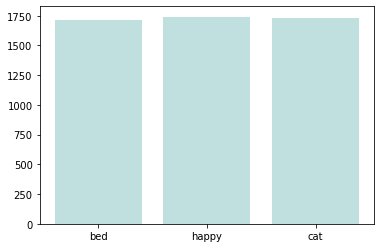

In [32]:
plt.bar(CLASSES, counts, color="#c0e0e0")
plt.show()

This helps us visualize if there is any form of class imbalance. We can see that the number of data points are fairly equal and therefore we need not worry about any sort of imbalance between classes

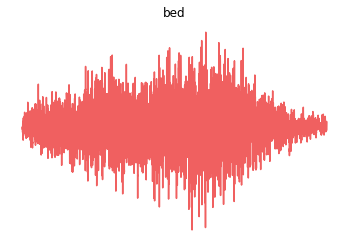

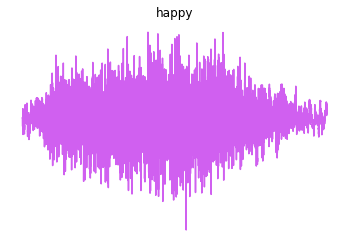

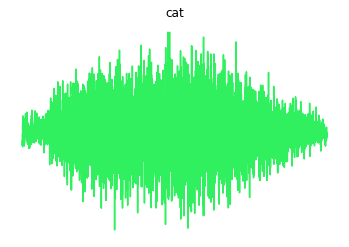

In [33]:
colors = ["#f06060", "#d060f0", "#30f060"]

for cl, col in zip(CLASSES, colors):
    # find the mean of all waves for a particular class with length = 16000
    audio = np.mean([x for x, c in data if c == cl and len(x) == 16000], axis=0)

    plt.plot(audio, color=col)
    plt.title(cl)
    plt.axis("off")

    plt.show()

The above three plots show the mean of the waves for each class. We can see subtle differences such as the number of peaks, the point where the speech wave peaks is different, etc. We hope that the LSTM avails these differences to distinguish between the speach patterns and, therefore, correctly classifiy the speech word.

## Data Preparation for Learning

### Writing the Preprocessor

In [0]:
def preprocess(data, labels, one_hot_enc=None):
    """
    This function preprocesses the the data to extract mfcc features for each audio
    track and one-hot encodes all the labels
    
    params:
        data
            list of audio waves extracted using librosa
        
        labels
            list of labels (integer or label names)
            
        one_hot_enc
            object that has a method transform which transforms list of labels to their
            one hot encoded form
            
    returns:
        X
            list of transformed features corresponding to data passed as input
        
        y
            list of one-hot encoded labels
        
    """

    if one_hot_enc is None:
        raise ValueError("one_hot_enc cannot be None")

    import librosa
    import numpy as np

    # fix length of audio tracks (pad if shorter, crop if longer)
    X = np.array([librosa.util.fix_length(x, 16000) for x in data])
    X = np.array([librosa.feature.mfcc(x, sr=16000) for x in X]) #Mel filter cepstral coefficients (MFCC)

    y = np.array([[l] for l in labels])
    y = one_hot_enc.transform(y).toarray()

    return X, y

### Creating the Preprocessor

In [35]:
# define the one-hot encoder

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(np.array([[cl] for cl in CLASSES]))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

Creating the one-hot encoder to convert prediction classes into one-hot encoded variables

### Preprocessing the Data

In [0]:
# split the unprocessed data to covariates and labels

data, labels = zip(*data)

In [40]:
print(data[0].shape)
print(labels[0])

(16000,)
bed


The zip function when passed in this manner separates the list of lists into separate lists

In [0]:
# preprocess the data to be used later

X, y = preprocess(data, labels,enc)

In [43]:
X.shape # our mfcc transformation outputs to 32 x input features

(5188, 20, 32)

In [49]:
# Example of that transformation from preprocessor for one audio file looks like:
aud_step1=np.array(librosa.util.fix_length(data[0], 16000)) #set audio data length to 16000
print(aud_step1.shape)
aud_step2=np.array(librosa.feature.mfcc(aud_step1, sr=16000)) #mfcc conversion
print(aud_step2.shape)
# every observation has 20 resulting timesteps and 32 x input features.

(16000,)
(20, 32)


In [50]:
y.shape

(5188, 3)

### Defining Train and Test Data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

Split data into train/test data with a 70-30 split

## Learning and Predicting

### Defining the Model

In [0]:
# Load libraries

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import LSTM,Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop



# defining the model

hidden_size = 200

dense_out_1 = 20
dense_out_2 = 10
dense_out_3 = len(CLASSES)

model = Sequential()
model.add(LSTM(hidden_size))
model.add(Dense(dense_out_1, activation="relu"))
model.add(Dense(dense_out_2, activation="relu"))
model.add(Dense(dense_out_3, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Here we define the actual model.

- The Sequential object defines a sequential object which allows computations in a sequential manner, like the layers of a neural network
- To the defined sequential object, we add our first layer which is a LSTM cell with the hidden representation of dimensionality 20. This LSTM takes in the features and computes a hidden state. This state is used to compute the output.
- We add two dense (neural network) layers to the model which takes in input the hidden state from the LSTM and applies three-layer neural network (of sizes 20 x 10 x 3) over the states to compute the final prediction using softmax regression

At last, we compile the model to use cross entropy loss (most common loss function for softmax regression) and set the optimizer to adam. The metrics arguent specifies what else should the model report other than the losses for the train and validation (here, test) data

### Learning the Network

In [55]:
# fitting the network. Output indicates we should consider slowing down learning process with Dropout.

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=72,
        validation_data=(X_test, y_test),
        verbose=2,
        shuffle=True,
    )

Epoch 1/50
51/51 - 4s - loss: 1.0841 - accuracy: 0.3878 - val_loss: 1.0680 - val_accuracy: 0.4021
Epoch 2/50
51/51 - 3s - loss: 0.9879 - accuracy: 0.5189 - val_loss: 1.0162 - val_accuracy: 0.4997
Epoch 3/50
51/51 - 4s - loss: 0.8608 - accuracy: 0.6210 - val_loss: 0.9780 - val_accuracy: 0.5183
Epoch 4/50
51/51 - 3s - loss: 0.7146 - accuracy: 0.7078 - val_loss: 0.9337 - val_accuracy: 0.5645
Epoch 5/50
51/51 - 3s - loss: 0.5610 - accuracy: 0.7835 - val_loss: 0.8670 - val_accuracy: 0.6191
Epoch 6/50
51/51 - 4s - loss: 0.4044 - accuracy: 0.8521 - val_loss: 0.8585 - val_accuracy: 0.6333
Epoch 7/50
51/51 - 3s - loss: 0.2846 - accuracy: 0.9072 - val_loss: 0.8595 - val_accuracy: 0.6635
Epoch 8/50
51/51 - 3s - loss: 0.1954 - accuracy: 0.9394 - val_loss: 0.9719 - val_accuracy: 0.6480
Epoch 9/50
51/51 - 4s - loss: 0.1279 - accuracy: 0.9681 - val_loss: 0.9908 - val_accuracy: 0.6737
Epoch 10/50
51/51 - 3s - loss: 0.0841 - accuracy: 0.9793 - val_loss: 1.0429 - val_accuracy: 0.6699
Epoch 11/50
51/51 -

This trains the model. For each sample, the LSTM is run on all the time steps and the final classification is done using the hidden state of the last step. Then the loss is back-propogated over the complete cycle. 

The fit function also returns the list of training and test losses we see over time and this is recorded in the `history` variable. We plot these losses in the next cell in order to confirm if the training went as we would expect.

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                multiple                  186400    
_________________________________________________________________
dense_3 (Dense)              multiple                  4020      
_________________________________________________________________
dense_4 (Dense)              multiple                  210       
_________________________________________________________________
dense_5 (Dense)              multiple                  33        
Total params: 190,663
Trainable params: 190,663
Non-trainable params: 0
_________________________________________________________________


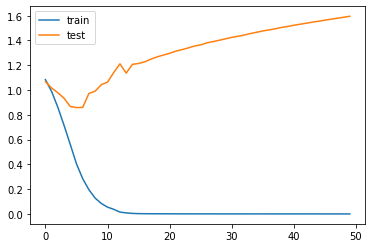

In [57]:
# plotting the training and test lloss

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

### Evaluating the Fit

In [0]:
estimator = KerasClassifier(build_fn=lambda: model, epochs=15, batch_size=64, verbose=2)

kfold = KFold(n_splits=10, shuffle=True)

results = cross_val_score(estimator, X, y, cv=kfold)

Epoch 1/15
 - 0s - loss: 0.9189 - accuracy: 0.6299
Epoch 2/15
 - 0s - loss: 0.8549 - accuracy: 0.6303
Epoch 3/15
 - 0s - loss: 0.8102 - accuracy: 0.6492
Epoch 4/15
 - 0s - loss: 0.7914 - accuracy: 0.6595
Epoch 5/15
 - 0s - loss: 0.7762 - accuracy: 0.6706
Epoch 6/15
 - 0s - loss: 0.7610 - accuracy: 0.6751
Epoch 7/15
 - 0s - loss: 0.7497 - accuracy: 0.6749
Epoch 8/15
 - 0s - loss: 0.7403 - accuracy: 0.6774
Epoch 9/15
 - 0s - loss: 0.7262 - accuracy: 0.6886
Epoch 10/15
 - 0s - loss: 0.7179 - accuracy: 0.6965
Epoch 11/15
 - 0s - loss: 0.7129 - accuracy: 0.6954
Epoch 12/15
 - 0s - loss: 0.6967 - accuracy: 0.7042
Epoch 13/15
 - 0s - loss: 0.6968 - accuracy: 0.7023
Epoch 14/15
 - 0s - loss: 0.6876 - accuracy: 0.7085
Epoch 15/15
 - 0s - loss: 0.6783 - accuracy: 0.7061
Epoch 1/15
 - 0s - loss: 0.7224 - accuracy: 0.6894
Epoch 2/15
 - 0s - loss: 0.7011 - accuracy: 0.7001
Epoch 3/15
 - 0s - loss: 0.6875 - accuracy: 0.7066
Epoch 4/15
 - 0s - loss: 0.6798 - accuracy: 0.7113
Epoch 5/15
 - 0s - loss: 

In [58]:
model.evaluate(X_test, y_test)

49/49 [==============================] - 1s 15ms/step - loss: 1.5937 - accuracy: 0.7193


[1.593716025352478, 0.7193320393562317]

In [60]:
model.predict(X_test)[0] # predicts first test audio file is "bed" (one hot data first class column has greatest softmax value)

array([9.9770987e-01, 6.7841279e-06, 2.2833743e-03], dtype=float32)

In [61]:
y_test[0] # true!

array([1., 0., 0.])